<h1>Minimum Distance Analysis for Field Emission from a Ring-Shaped Emitter

<h3>Import

In [46]:
# Math
import numpy as np
import math as m
# Data
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme()

<h4>Functions

In [47]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    ave_min_dist = np.mean(data['min_dist'])
    std_min_dist = np.std(data['min_dist'])
    return ave_min_dist, std_min_dist
    

<h4>Fetch data

In [48]:
max_height = 1.5e-9

simul_param = {
    # 100: {'time_start': 2500, 'time_end': 4000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    200: {'time_start': 2000, 'time_end': 2500, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    300: {'time_start': 2000, 'time_end': 4000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    400: {'time_start': 2000, 'time_end': 4000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    500: {'time_start': 1300, 'time_end': 2000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    600: {'time_start': 1500, 'time_end': 2500, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    700: {'time_start': 1000, 'time_end': 3000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    800: {'time_start': 1000, 'time_end': 3000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    900: {'time_start': 1000, 'time_end': 3000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    1000: {'time_start': 1000, 'time_end': 2000, 'time_step': 50, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
}

simul_data = {'E0': [], 'E': [], 'dE': [], 'd': [], 'd_th': []}

In [ ]:
epsilon_0 = 8.854187817e-12
q = 1.60217662e-19

elecbase = f'/out/elec-'
elec_dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('min_dist', np.float64)])

fieldbase = '/out/field-'
field_dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('field', np.float64)])

# fig = plt.figure(figsize=(10, 8))
for voltage,simulation in simul_param.items():

    time_steps = np.arange(simulation['time_start'], simulation['time_end']+1, simulation['time_step'], dtype=int)
    for time_step in time_steps:

        # Get field data
        field_filename = f'./V{voltage}{fieldbase}{time_step}.bin'
        data_mem_abs = np.memmap(field_filename, dtype=field_dt_abs_type, mode='r', order='F')
        field_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)

        # Get distance data
        elec_filename = f'./V{voltage}{elecbase}{time_step}.bin'
        data_mem_abs = np.memmap(elec_filename, dtype=elec_dt_abs_type, mode='r', order='F')
        elec_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)
        elec_data = elec_data[(elec_data['z'] >= simulation['d_min']) & (elec_data['z'] <= simulation['d_max'])]

        # Field calculations
        E = field_data['field'].mean()
        E0 = voltage/simulation['distance']

        # plt.plot(E0,E,'o')

        # Distance calculations
        d_th = m.sqrt(q*simulation['distance']/(m.pi*epsilon_0*voltage))
        # d_th = m.sqrt(q/(m.pi*epsilon_0*E))

        # Store data
        for i in range(len(elec_data)):
            simul_data['E0'].append(E0)
            simul_data['E'].append(E)
            simul_data['dE'].append(E0 - E)
            simul_data['d'].append(elec_data.iloc[i]['min_dist'])
            simul_data['d_th'].append(d_th)

# plt.show()
# Change to dataframe
dist_data = pd.DataFrame.from_dict(simul_data)

<Figure size 1000x800 with 0 Axes>

<h4>Minimum distance as a function of field

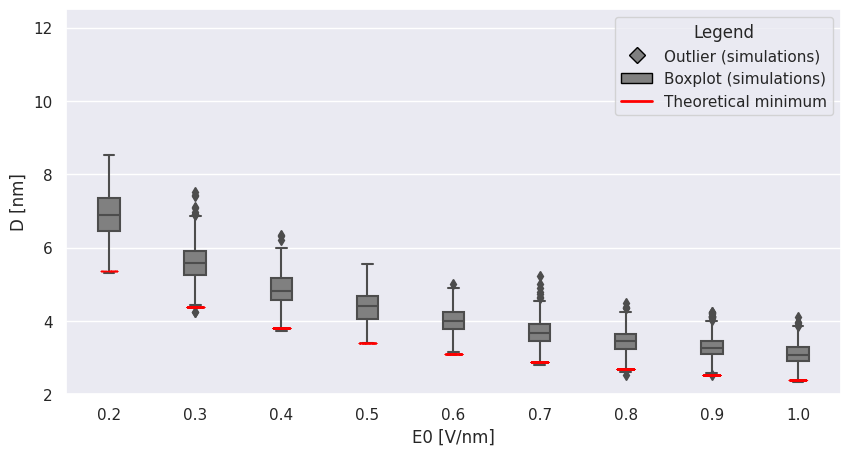

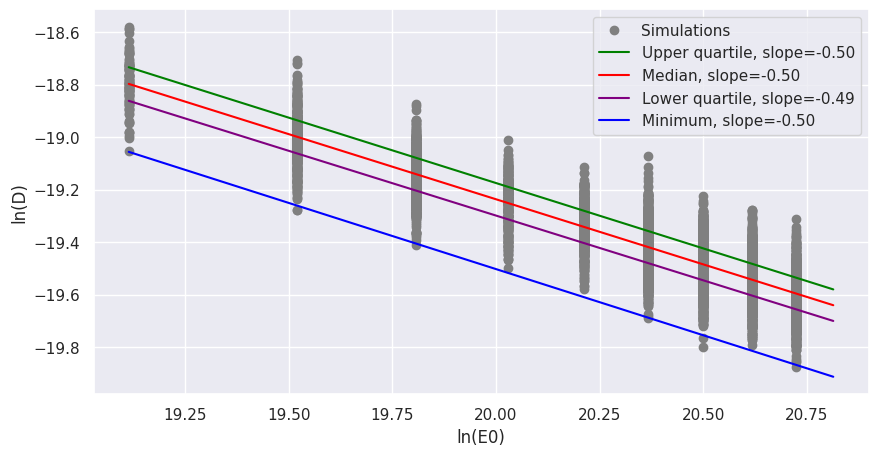

In [50]:
field = 'E0'

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=dist_data, x=round(dist_data[field]*1e-9,2), y=dist_data['d']*1e9, ax=ax, showfliers=True, color='grey', width=0.25)
sns.stripplot(data=dist_data, x=round(dist_data[field]*1e-9,2), y=dist_data['d_th']*1e9, ax=ax, color='red', size=1)
plt.xlim(-0.5,len(simul_param)-0.5)
plt.ylim(2,12.5)
plt.xlabel(f'{field} [V/nm]')
plt.ylabel('D [nm]')
diamond_handle = Line2D([0], [0],
                    marker='D',
                    color='black',
                    markerfacecolor='grey',
                    markersize=8,
                    linestyle='None',
                    label='Outlier (simulations)')

rectangle_handle = Patch(facecolor='grey',
                   edgecolor='black',
                   label='Boxplot (simulations)')
line_handle    = Line2D([0], [0], 
                    color='red',
                    linestyle='-',
                    linewidth=2,
                    label='Theoretical minimum')

ax.legend(handles=[diamond_handle,rectangle_handle, line_handle],
          title='Legend')
plt.show()



# Log-transform
logE = np.log(dist_data[field])
logD = np.log(dist_data['d'])

# Linear fit
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(logE, logD, 'o', label='Simulations', color='grey')

logE_fit_q = np.arange(min(logE), max(logE)+0.1, 0.1)

quartiles = [0.75, 0.50, 0.25, 0.0]
colors = ['green', 'red', 'purple', 'blue']

for i,q in enumerate(quartiles):
    # Find the quartile
    if (quartiles[i] == 0.0):
        temp_data = dist_data.groupby(by=field, as_index=False).min()
    else:
        temp_data = dist_data.groupby(by=field, as_index=False).quantile(q=q)

    # for e0 in temp_data[field]:
    #     print(f'E0: {e0:.2f} V/nm')
    #     print(f'nr of points: {len(dist_data[dist_data[field] == e0])}')

    
    # Fit the data
    logE_q = np.log(temp_data[field])
    logD_q = np.log(temp_data['d'])
    
    # Linear fit
    slope, intercept = np.polyfit(logE_q, logD_q, 1)
    logD_fit_q = slope*logE_fit_q + intercept

    # Plot the data
    if (quartiles[i] == 0.0):
        label = 'Minimum'
    elif (quartiles[i] == 0.25):
        label = 'Lower quartile'
    elif (quartiles[i] == 0.50):
        label = 'Median'
    else:
        label = 'Upper quartile'

    ax.plot(logE_fit_q, logD_fit_q, label=f'{label}, slope={slope:.2f}', color=colors[i])
ax.set_xlabel(f'ln({field})')
ax.set_ylabel('ln(D)')
ax.legend()
plt.show()